# Denoising Autoencoder

A denoising autoencoder is pretty much like a regular autoencoder except that the input $X$ (e.g. an image) is perturbed with some noise, say with an additive Gaussian noise, and the autoencoder is trained to reconstruct the unperturbed input $X$.

Adding noise to the input has a positive generalization impact on the autoencoder and forces the autoencoder to learn a meaningful representation. Indeed, the autoencoder has to learn to reconstruct inputs from noisy signals and thus has to learn the structure of the manifold underlying the data set. With a regular autoencoder, if the latent code (representation) has a larger dimension than the input (we say that the autoencoder is over-complete), then the autoencoder could learn the identity mapping and reconstruct inputs perfectly. However, representations from such an autoencoder wouldn't be useful. A denoising autoencoder prevents such pathological behavior.

In terms of code, the changes with respect to a regular autoenoder are **very minimal**.

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on GPU


Let's load the MNIST data set.

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Create a *loader* to feed the data batch by batch during training.

In [4]:
batch = 300
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch, shuffle=True)

Now, we define the **autoencoder**.

In [5]:
autoencoder = nn.Sequential(
                # Encoder
                nn.Linear(28 * 28, 512),
                nn.PReLU(512),
                nn.BatchNorm1d(512),
    
                # Low-dimensional representation
                nn.Linear(512, 128),   
                nn.PReLU(128),
                nn.BatchNorm1d(128),
    
                # Decoder
                nn.Linear(128, 512),
                nn.PReLU(512),
                nn.Linear(512, 28 * 28))

autoencoder = autoencoder.type(FloatTensor)

We define the optimization scheme (here **Adam**) for the autoencoder.

In [6]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)

Finally, we train the autoencoder.

In [7]:
epochs = 10
data_size = int(mnist.train_labels.size()[0])

for i in range(epochs):
    for j, (images, _) in enumerate(data_loader):
        images = images.view(images.size(0), -1).type(FloatTensor)
        images_noisy = images + 0.2 * torch.randn(images.size()).type(FloatTensor) # adding noise
        images = Variable(images, requires_grad=False)
        images_noisy = Variable(images_noisy)

        autoencoder.zero_grad()
        reconstructions = autoencoder(images_noisy) # forward noisy images
        loss = torch.dist(images, reconstructions) # compare reconstructions to unperturbed images
        loss.backward()
        optimizer.step()
    print('Epoch %i/%i loss %.4f' % (i + 1, epochs, loss.data[0]))

Epoch 1/10 loss 148.6719
Epoch 2/10 loss 129.4973
Epoch 3/10 loss 116.5954
Epoch 4/10 loss 113.3039
Epoch 5/10 loss 109.7533
Epoch 6/10 loss 107.1297
Epoch 7/10 loss 104.0446
Epoch 8/10 loss 103.6882
Epoch 9/10 loss 101.1380
Epoch 10/10 loss 100.3909


Let's plot some images along their reconstructions.

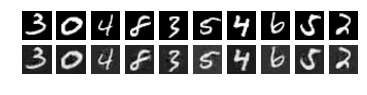

In [8]:
images = images.view(batch, 28, 28).data.cpu().numpy()
reconstructions = reconstructions.view(batch, 28, 28).data.cpu().numpy()

fig = plt.figure(figsize=(6, 6))
for i in range(10):
    a = fig.add_subplot(10, 10, i + 1)
    b = fig.add_subplot(10, 10, i + 11)
    a.axis('off')
    b.axis('off')
    image = images[i - 1]
    reconstruction = reconstructions[i - 1]
    a.imshow(image, cmap='Greys_r')
    b.imshow(reconstruction, cmap='Greys_r');